# Projecting playoff success
Being 5- to 7-game playoff rounds, do we get enough data points to project,
* Does regular season success based on the team measures provide insights into playoff success run?
* How much of regular season success and gap between the teams lead to quicker finish (not necessarily reaching to game 5 or 7)?
* Does the regular season success (and what threshold) project the stanley cup winner?

In [14]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator
plt.rcParams.update({'font.size': 16})
plt.style.use('ggplot')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
#model = LogisticRegression(solver='liblinear', random_state=0)
# Or different approach
import numpy as np
import statsmodels.api as sm
# print result in latex
from stargazer.stargazer import Stargazer, LineLocation
from IPython.core.display import HTML

In [15]:
import os
cwd = os.getcwd()
cwd_git = os.path.dirname(os.path.dirname(os.path.dirname(cwd)))

import sys
sys.path.append(cwd_git)

import credentials
from credentials import cwd_data

#str_origin = "----- Your dir -----"
str_data = cwd_data + "nhl/data_gamelvl/data"


# import relevant functions
str_dir_sourceCode = cwd_git+"/NHL-Analytics/src/measurement"


# Pull all historical data

In [17]:
# Team box score
idx_yr_last = 2023
list_years = np.arange(2011, idx_yr_last)

# Pull regular season statistics of each team
df_reg = []
for iter in list_years:
    tempdf = pd.read_csv(str_data + f'/processed/{iter}_02_team.csv')
    if iter == 2011:
        df = tempdf
    else:
        df = pd.concat([df, tempdf])

df_reg = df
df_reg.rename(columns = {"team_tri_for":"team_tri"}, inplace = True)

df_plf = []
for iter in list_years:
    tempdf = pd.read_csv(str_data + f'/cleaned/{iter}_03_box.csv')
    tempdf.loc[:,'yr_season'] = iter
    if iter == 2011:
        df = tempdf
    else:
        df = pd.concat([df, tempdf])

df_plf = df

# Adding some ranking columns for relative comparisons
df_reg["rank_corsi"] = df_reg.groupby(["yr_season"])["kpi_corsi"].rank(ascending = False)
df_reg["rank_fenwick"] = df_reg.groupby(["yr_season"])["kpi_fenwick"].rank(ascending = False)
df_reg["rank_rpi"] = df_reg.groupby(["yr_season"])["kpi_rpi"].rank(ascending = False)
df_reg["rank_pe"] = df_reg.groupby(["yr_season"])["kpi_pe"].rank(ascending = False)
df_reg["rank_pairwise"] = df_reg.groupby(["yr_season"])["kpi_pairwise"].rank(ascending = False)
df_reg["rank_rpi"] = df_reg.groupby(["yr_season"])["kpi_rpi"].rank(ascending = False)

# Cumulative statistics to be used
df_plf["plf_gamecount"] = df_plf.groupby(["yr_season","team_tri"]).cumcount() + 1
# Playoff game series count
df_plf["series"] = [iter[0:7] for iter in df_plf.gameIdx]
df_plf["series_date"] = [iter[8:] for iter in df_plf.gameIdx]
tempdf = df_plf.groupby(["yr_season","series"]).team_tri.count()/2
tempdf = tempdf.reset_index().rename(columns={"team_tri":"series_gamecount"})
df_plf = pd.merge(df_plf, tempdf, on = ["yr_season","series"], how = "left")
# For each series, count game number (n-th game of each series)
df_plf["series_gamenum"] = df_plf.groupby(["yr_season","series","team_tri"])\
    .team_tri.cumcount()+1
# Tournament advance count (1 (first-round) - 4 (final))
tempdf = df_plf\
    .groupby(["yr_season","series","team_tri"]).series_gamecount.max()\
    .reset_index()\
    .groupby(["yr_season", "team_tri"]).series_gamecount.count()\
    .reset_index().rename(columns={"series_gamecount":"playoff_count"})
df_plf = pd.merge(df_plf, tempdf, on = ["yr_season","team_tri"], how = "left")

# Game level match with home-away team statistics
df = pd.merge(df_reg, df_plf, on = ["team_tri", "yr_season"], how = "right")
df_home = df.loc[df.loc[:,"team_vis"] == "home",:]
df_away = df.loc[df.loc[:,"team_vis"] == "away",:]
df_match = pd.merge(df_home, df_away, on = ["gameIdx"], how = "inner", suffixes=("_home", "_away"))

# Is the regular season performance metrics a good predictor for playoff game outcomes?

In [18]:
# Pairwise rank - lower number means higher rank
rpi_check = \
    (df_match.loc[:,"kpi_rpi_home"] >= df_match.loc[:,"kpi_rpi_away"]) \
    == \
    (df_match.loc[:,"win_home"] >= df_match.loc[:,"win_away"])

df_rpi = pd.DataFrame(rpi_check, columns = ["proj_rpi"])
df_rpi["series_gamenum"] = df_match["series_gamenum_home"]
df_rpi["rpi_gap"] = df_match.kpi_rpi_home - df_match.kpi_rpi_away

# This is very disappointing
df_rpi.proj_rpi.value_counts()

proj_rpi
True     549
False    547
Name: count, dtype: int64

Observing by games played for each series - the first two games are evenly split in outcome regardless of regular season outcomes. Game 3 and 4 historically tend to slightly favor teams with better regular season performance. Game 7 is the most intriguing, where better regular season performing teams have won more games.

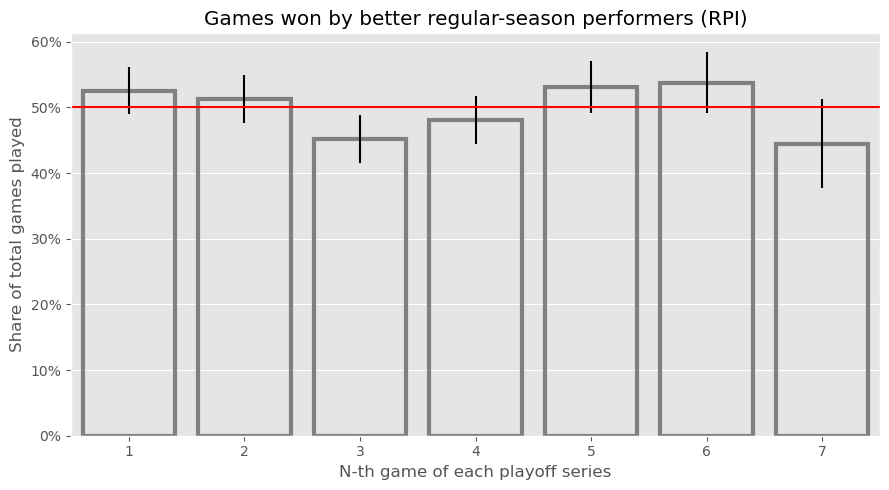

In [19]:
tempdf = df_rpi.groupby(["series_gamenum", "proj_rpi"]).count().reset_index()
tempdf = tempdf.loc[tempdf.proj_rpi == True,["series_gamenum","rpi_gap"]]\
    .set_index("series_gamenum")\
    .join(tempdf.groupby(["series_gamenum"]).rpi_gap.sum(), rsuffix = "_total")
tempdf["ratio"] = tempdf.rpi_gap / tempdf.rpi_gap_total * 100
tempdf["stds"]    = np.sqrt(tempdf.ratio/100*(1-tempdf.ratio/100)/tempdf.rpi_gap_total) * 100

plt.figure(figsize=(9,5))
ax = sns.barplot(
    data=tempdf.reset_index(), x="series_gamenum", y="ratio", yerr=tempdf["stds"] ,
    capsize=.4, errcolor=".5",
    linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0),
)

ax.set(xlabel='N-th game of each playoff series',
       ylabel='Share of total games played',
       title='Games won by better regular-season performers (RPI)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.axhline(50, color = "red")
#plt.show()

plt.tight_layout()
plt.savefig("regtocup_rpi.png", dpi=300)

Repeat above but with different KPIs. For pairwise, the measure seems to be more favorable with better regular season performer - thus able to project the winner with better confidence (than RPI).

In [20]:
# Pairwise rank - lower number means higher rank
pairwise_check = \
    (df_match.loc[:,"kpi_pairwise_home"] >= df_match.loc[:,"kpi_pairwise_away"]) \
    == \
    (df_match.loc[:,"win_home"] >= df_match.loc[:,"win_away"])

df_pairwise = pd.DataFrame(pairwise_check, columns = ["proj_pairwise"])
df_pairwise["series_gamenum"] = df_match["series_gamenum_home"]
df_pairwise["pairwise_gap"] = df_match.loc[:,"kpi_pairwise_home"] - df_match.loc[:,"kpi_pairwise_away"]

# This is very disappointing
df_pairwise.proj_pairwise.value_counts()
#sns.kdeplot(data = df_pairwise, x="pairwise_gap", hue="proj_pairwise")

proj_pairwise
True     565
False    531
Name: count, dtype: int64

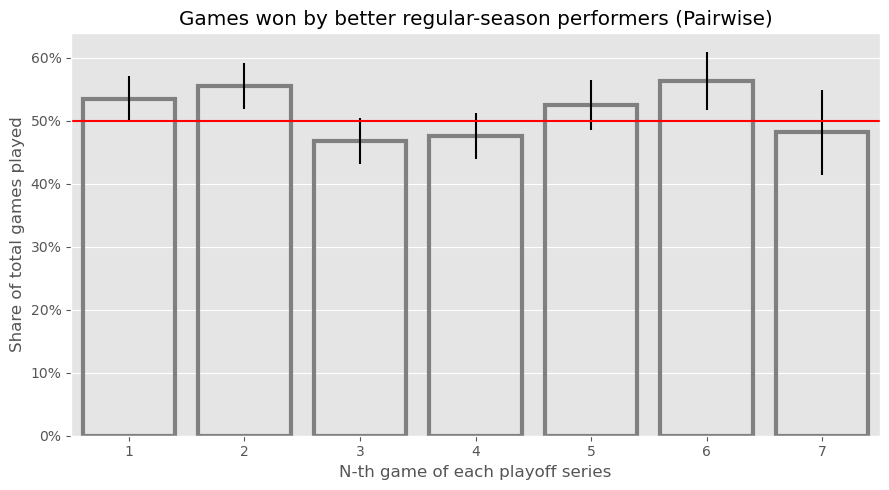

In [21]:
tempdf = df_pairwise.groupby(["series_gamenum", "proj_pairwise"]).count().reset_index()
tempdf = tempdf.loc[tempdf.proj_pairwise == True,["series_gamenum","pairwise_gap"]]\
    .set_index("series_gamenum")\
    .join(tempdf.groupby(["series_gamenum"]).pairwise_gap.sum(), rsuffix = "_total")
tempdf["ratio"] = tempdf.pairwise_gap / tempdf.pairwise_gap_total * 100
tempdf["stds"]    = np.sqrt(tempdf.ratio/100*(1-tempdf.ratio/100)/tempdf.pairwise_gap_total) * 100

plt.figure(figsize=(9,5))
ax = sns.barplot(
    data=tempdf.reset_index(), x="series_gamenum", y="ratio", yerr=tempdf["stds"] ,
    capsize=.4, errcolor=".5",
    linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0),
)

ax.set(xlabel='N-th game of each playoff series',
       ylabel='Share of total games played',
       title='Games won by better regular-season performers (Pairwise)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.axhline(50, color = "red")

plt.tight_layout()
plt.savefig("regtocup_pairwise.png", dpi=300)

In [22]:
# Pythagorean expectation
pythagoreanexpectation_check = \
    (df_match.loc[:,"kpi_pe_home"] >= df_match.loc[:,"kpi_pe_away"]) \
    ==\
    (df_match.loc[:,"win_home"] >= df_match.loc[:,"win_away"])

df_pe = pd.DataFrame(pythagoreanexpectation_check, columns = ["proj_pe"])
df_pe["series_gamenum"] = df_match["series_gamenum_home"]
df_pe["pe_gap"] = df_match.loc[:,"kpi_pe_home"] - df_match.loc[:,"kpi_pe_away"]


# This is very disappointing
pythagoreanexpectation_check.value_counts()

True     564
False    532
Name: count, dtype: int64

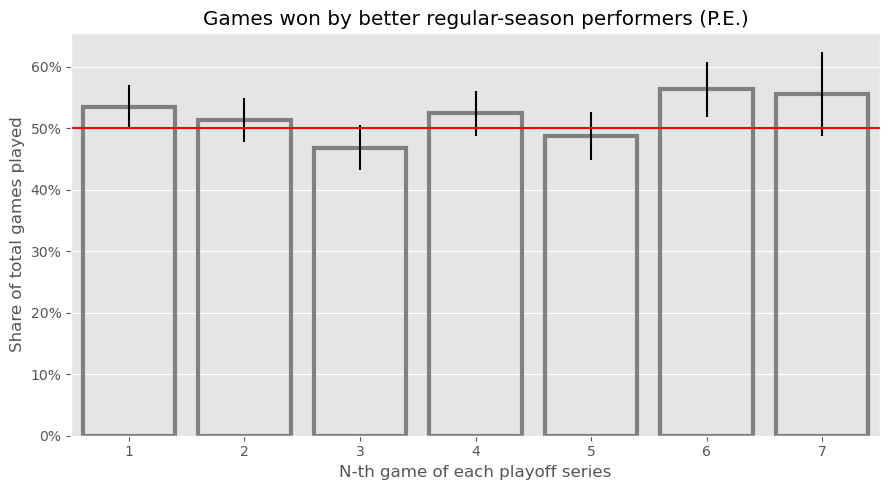

In [23]:
tempdf = df_pe.groupby(["series_gamenum", "proj_pe"]).count().reset_index()
tempdf = tempdf.loc[tempdf.proj_pe == True,["series_gamenum","pe_gap"]]\
    .set_index("series_gamenum")\
    .join(tempdf.groupby(["series_gamenum"]).pe_gap.sum(), rsuffix = "_total")
tempdf["ratio"] = tempdf.pe_gap / tempdf.pe_gap_total * 100
tempdf["stds"]    = np.sqrt(tempdf.ratio/100*(1-tempdf.ratio/100)/tempdf.pe_gap_total) * 100

plt.figure(figsize=(9,5))
ax = sns.barplot(
    data=tempdf.reset_index(), x="series_gamenum", y="ratio", yerr=tempdf["stds"] ,
    capsize=.4, errcolor=".5",
    linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0),
)

ax.set(xlabel='N-th game of each playoff series',
       ylabel='Share of total games played',
       title='Games won by better regular-season performers (P.E.)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.axhline(50, color = "red")

plt.tight_layout()
plt.savefig("regtocup_pe.png", dpi=300)

In [24]:
# Pythagorean expectation
wp_check = \
    (df_match.loc[:,"wp_home"] >= df_match.loc[:,"wp_away"]) \
    ==\
    (df_match.loc[:,"win_home"] >= df_match.loc[:,"win_away"])

df_wp = pd.DataFrame(wp_check, columns = ["proj_wp"])
df_wp["series_gamenum"] = df_match["series_gamenum_home"]#df_plf["series_gamenum"]
df_wp["wp_gap"] = df_match.loc[:,"wp_home"] - df_match.loc[:,"wp_away"]


# This is very disappointing
wp_check.value_counts()

True     559
False    537
Name: count, dtype: int64

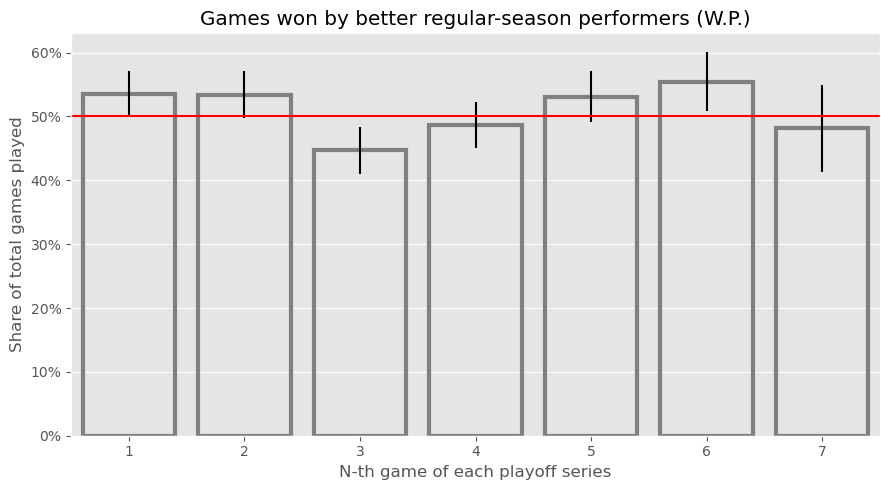

In [25]:
tempdf = df_wp.groupby(["series_gamenum", "proj_wp"]).count().reset_index()
tempdf = tempdf.loc[tempdf.proj_wp == True,["series_gamenum","wp_gap"]]\
    .set_index("series_gamenum")\
    .join(tempdf.groupby(["series_gamenum"]).wp_gap.sum(), rsuffix = "_total")
tempdf["ratio"] = tempdf.wp_gap / tempdf.wp_gap_total * 100
tempdf["stds"]    = np.sqrt(tempdf.ratio/100*(1-tempdf.ratio/100)/tempdf.wp_gap_total) * 100

plt.figure(figsize=(9,5))
ax = sns.barplot(
    data=tempdf.reset_index(), x="series_gamenum", y="ratio", yerr=tempdf["stds"] ,
    capsize=.4, errcolor=".5",
    linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0),
)

ax.set(xlabel='N-th game of each playoff series',
       ylabel='Share of total games played',
       title='Games won by better regular-season performers (W.P.)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.axhline(50, color = "red")

plt.tight_layout()
plt.savefig("regtocup_wp.png", dpi=300)

# How many top regular season teams won the cup?
* The only regular season top-performing team that won the Stanley Cup in the last decade is the Chicago Blackhawks in 2012-2013 season.
* Strong Corsi and Fenwick metric has not been a good indicator of the winner in recent years. 2017 Washington Captial team was one of the worst performing Stanley Cup winning team based on the two metrics. 
* Based on the pairwise and RPI metric, broader measures of team wins relative to their competitions, most teams has been consistently rank top 6 of the regular season - at most top1 2.
* Number of games to Stanley Cup win varies and does not seem to have a direct relationship of regular season performance to less games needed to win it all.

In [26]:
# Records of stanley cup winner, and their relative team goals 
stanley_winner = df.loc[df.win == 1, :].groupby(["yr_season"]).tail(1)
stanley_winner.set_index(["yr_season", "team_tri"], inplace = True)
stanley_winner[
    [
        "plf_gamecount","series_gamecount",
        "rank_fenwick", "rank_corsi",
        "rank_pairwise", "rank_rpi", "rank_pe"
    ]
]


,,plf_gamecount,series_gamecount,rank_fenwick,rank_corsi,rank_pairwise,rank_rpi,rank_pe
yr_season,team_tri,,,,,,,
2011,LAK,20,6.0,6.0,11.0,12.0,13.0,9.0
2012,CHI,23,6.0,3.0,2.0,1.5,1.0,1.0
2013,LAK,26,5.0,2.0,4.0,8.5,8.0,7.0
2014,CHI,23,6.0,3.0,15.0,11.0,12.0,5.0
2015,PIT,24,6.0,5.0,5.0,3.0,4.0,2.0
2016,PIT,25,6.0,11.0,6.0,2.0,3.0,4.0
2017,WSH,24,5.0,28.0,27.0,6.0,6.0,13.0
2018,STL,26,7.0,8.0,6.0,12.0,13.0,10.0
2019,TBL,25,6.0,11.0,14.0,2.0,2.0,2.0


In [27]:
stanley_winner_stack = stanley_winner[["rank_pairwise", "rank_rpi", "rank_pe"]]
stanley_winner_stack = stanley_winner_stack.rename(
    columns={"rank_pairwise":"Pairwise", "rank_rpi":"RPI", "rank_pe":"PE"}
    ).stack()
stanley_winner_stack = stanley_winner_stack.reset_index()
stanley_winner_stack.rename(columns={"level_2":"Rank Type", 0:"Rank"}, inplace=True)
stanley_winner_stack['xcol'] = [str(val)+"\n("+stanley_winner_stack.team_tri[iter]+")" for iter,val in enumerate(stanley_winner_stack.yr_season)]

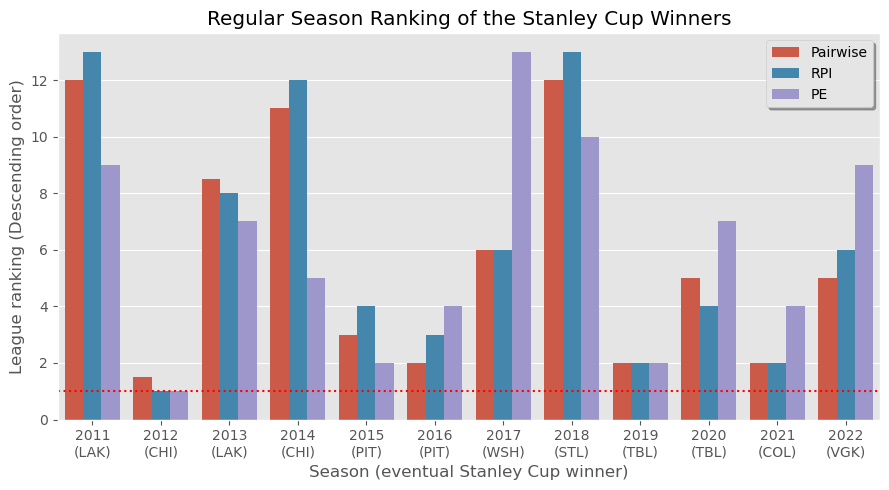

In [28]:
plt.figure(figsize=(9,5))
ax = sns.barplot(data = stanley_winner_stack, x="xcol", y="Rank", hue="Rank Type")
ax.set(xlabel='Season (eventual Stanley Cup winner)',
       ylabel='League ranking (Descending order)',
       title='Regular Season Ranking of the Stanley Cup Winners')
ax.axhline(1, color="red", linestyle=":")
ax.legend(loc='upper right', fancybox=True, shadow=True)
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18),
#          fancybox=True, shadow=True, ncol=5)
plt.tight_layout()
plt.savefig("regtocup_winners.png", dpi = 300)